# Task 4: ANN Modeling with KERAS

Members: Lars Olav Thorbjørnsen, Stein Are Årsnes og Sanjai Vijeyaratnam

### Abstract

This part of the project aims to create an Artificial Neural Network (ANN) machine learning algorithm to model and predict the Vp values based on the the different DEN, Vs and NEU values we have. By creating three layers with five nodes each, the goal will be to have the model learn from the data and it's mistakes to improve and predict better. 
We use the cleaned data, splitting it into two different parts so we can first train it, feeding it data so it can learn the patterns of it. Then we test it, letting it make a prediction before feeding it the actual results, letting it use back-propogation to improve. From our findings, it seems the model is fairly accurate, but it does overshoot, usually predicting a higher value than the actual results. It does still follow the pattern and trend of the data, proving that it is able to see the pattern of the data after training. 

### Introduction

Artificial Neural Network (ANN) are machine learning algorithms that contains layers and nodes to analyze and learn patterns in data. Similar to the brain and it's nervous system, ANN uses nodes to recieve input, analyze it, then pass it on to other nodes in the next layer, continuing this process until it arrives at a estimate. Then it will get the actual result and use back-propagation, a way of using the result to see where it went wrong and improve, fine tuning its findings to become better. 

In this part, we will find the Compressional Wave Velocity (Vp) based on data consisting of Shear Wave Velocity (Vs), Bulk Density (DEN), and Neutron Porosity (NEU) using ANN, so that we can make accurate predictions without worrying about mapping or using reggresion functions. We will use the pre-processed data to train and test the algorithm, hoping that its three layers will suffice in allowing it to learn the pattern of the data. We will then compare it to the actual results of the Vp to see how well it did. 

Importing the necessary data to create the ANN model

In [3]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

CleanedData = pd.read_excel('CleanedFeatureSelectedFiltered.xlsx')

TargetVariable = ['Vp']
Predictors = [['Vs'], ['DEN'], ['NEU'], 
              ['Vs', 'DEN'], ['Vs', 'NEU'], ['DEN', 'NEU'], 
              ['Vs', 'DEN', 'NEU']]

optimizers = ['adam', 'rmsprop']
activation_functions = {
    'relu': 'relu',
    'leaky_relu': LeakyReLU(alpha=0.1), 
    'swish': 'swish'
}

We load the cleaned dataset containing geological features to predict the Compressional Wave Velocity (Vp). We define the target variable (Vp) and several combinations of predictors (e.g., Shear Wave Velocity (Vs), Bulk Density (DEN), Neutron Porosity (NEU)). Additionally, we set up various optimizers (adam, rmsprop) and activation functions (relu, leaky_relu, swish) that will be tested in the ANN models. These combinations will allow us to explore how different inputs and model configurations affect the prediction accuracy.

In [4]:
def create_ann_model(input_dim, optimizer, activation):
    model = Sequential()
    model.add(Dense(units=5, input_dim=input_dim, kernel_initializer='normal', activation=activation))
    model.add(Dense(units=5, kernel_initializer='normal', activation=activation))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

This is the function we will use to create the ANN models. The ANN models contain three layers, with two of which containing five nodes. This function is used to call on with different optimizers and activation functions, and it also compiles the losses with the mean squared error function to make it suitable for regression. 

In [5]:
results = {}

# Loop through predictors, optimizers, and activation functions
for predictor_set in Predictors:
    X = CleanedData[predictor_set].values
    y = CleanedData[TargetVariable].values
    
    PredictorScaler = StandardScaler()
    TargetVarScaler = StandardScaler()
    
    X = PredictorScaler.fit_transform(X)
    y = TargetVarScaler.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for opt in optimizers:
        for act_name, act in activation_functions.items():
            model_name = f"{predictor_set}_{opt}_{act_name}"
            
            model = create_ann_model(input_dim=X_train.shape[1], optimizer=opt, activation=act)
          
            history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)
            
            test_loss = model.evaluate(X_test, y_test, verbose=0)
            predictions = model.predict(X_test)
            r2 = r2_score(y_test, predictions)
            
            results[model_name] = r2
            print(f"Model: {model_name}, R2 Score: {r2}")

10/10 [==============================] - 0s 2ms/step
Model: ['Vs']_adam_relu, R2 Score: 0.6956627854731313
10/10 [==============================] - 0s 2ms/step
Model: ['Vs']_adam_leaky_relu, R2 Score: 0.7072295369726187
10/10 [==============================] - 0s 3ms/step
Model: ['Vs']_adam_swish, R2 Score: 0.7184436111419685
10/10 [==============================] - 0s 2ms/step
Model: ['Vs']_rmsprop_relu, R2 Score: 0.7112159570256065
10/10 [==============================] - 0s 2ms/step
Model: ['Vs']_rmsprop_leaky_relu, R2 Score: 0.7080562105296999
10/10 [==============================] - 0s 2ms/step
Model: ['Vs']_rmsprop_swish, R2 Score: 0.7133315068525579
10/10 [==============================] - 0s 2ms/step
Model: ['DEN']_adam_relu, R2 Score: 0.8469840096914925
10/10 [==============================] - 0s 2ms/step
Model: ['DEN']_adam_leaky_relu, R2 Score: 0.8428919481327847
10/10 [==============================] - 0s 2ms/step
Model: ['DEN']_adam_swish, R2 Score: 0.8460674514423538
10/1

This section of the code performs training and evaluation of different ANN models. It loops through various combinations of predictor sets, optimizers, and activation functions. For each combination, it standardizes the data and split it into training and testing sets, calls the function and trains it for 500 epochs and then tested and evaluated with a $R^2$ score. The results are printed and stored. 

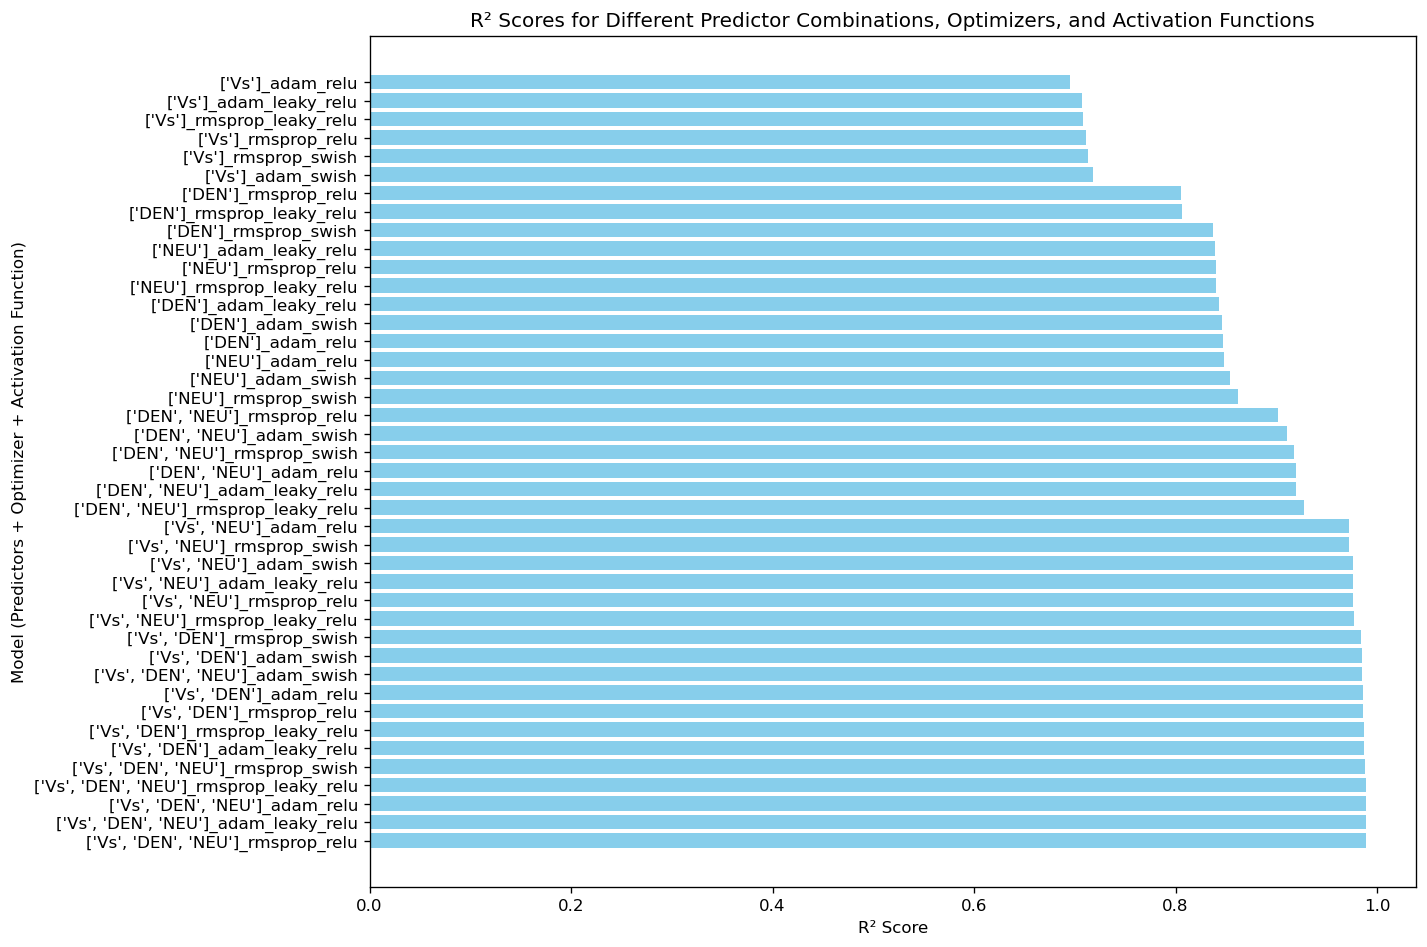

In [6]:
# Create a DataFrame from the results
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'R2_Score'])

# Sort by R² score (best to worst)
results_df = results_df.sort_values(by='R2_Score', ascending=False).reset_index(drop=True)

# Plot R² scores for all models
plt.figure(figsize=(12, 8), dpi=120)
plt.barh(results_df['Model'], results_df['R2_Score'], color='skyblue')
plt.xlabel('R² Score')
plt.ylabel('Model (Predictors + Optimizer + Activation Function)')
plt.title('R² Scores for Different Predictor Combinations, Optimizers, and Activation Functions')
plt.tight_layout()
plt.show()

Creates a dataframe to store all the $R^2$ scores from the different ADD models, where they are sorted from best to worst. It then generates a bar plot, giving us a visual representations of the different combinations and their respective $R^2$ values. 

The bar plot highlights the performance of different ANN model configurations in predicting the compressional wave velocity (Vp). The results show a clear trend where the models that used only one dataset (e.g., Vs, DEN, or NEU) consistently had the lowest R² scores, regardless of the optimizer or activation function used. 

As we move to models with two datasets, we see a significant improvement in performance. Interestingly, some of these combinations even outperformed models that used all three datasets. This suggests that certain pairs of features may provide complementary information that enhances model accuracy more than using all features in some cases. Or it could mean that certain pairs work worse together, as it seems like it is the trios using the swish activation functions were the ones that were close with the two dataset combinations. 

Nonetheless, the models that utilized all three datasets (Vs, DEN, and NEU) tended to perform the best overall. Among these top-performing models, the optimizer used varied between 'adam' and 'rmsprop,' but activation functions played a noticeable role. The top two models used the 'leaky_relu' activation, while the third and fourth models used 'relu.' This could indicate that while both activation functions performed well, 'leaky_relu' might provide a slight advantage in this context.

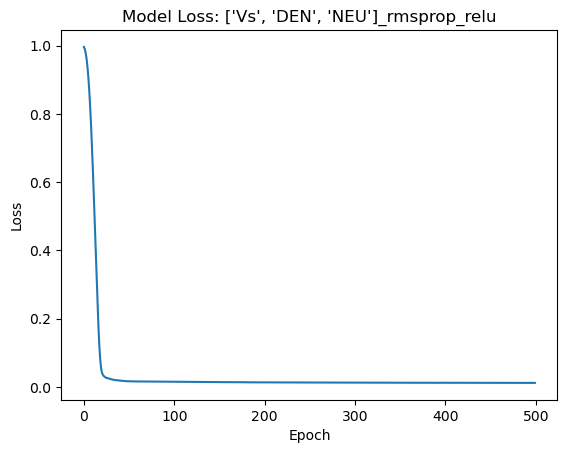

10/10 [==============================] - 0s 2ms/step


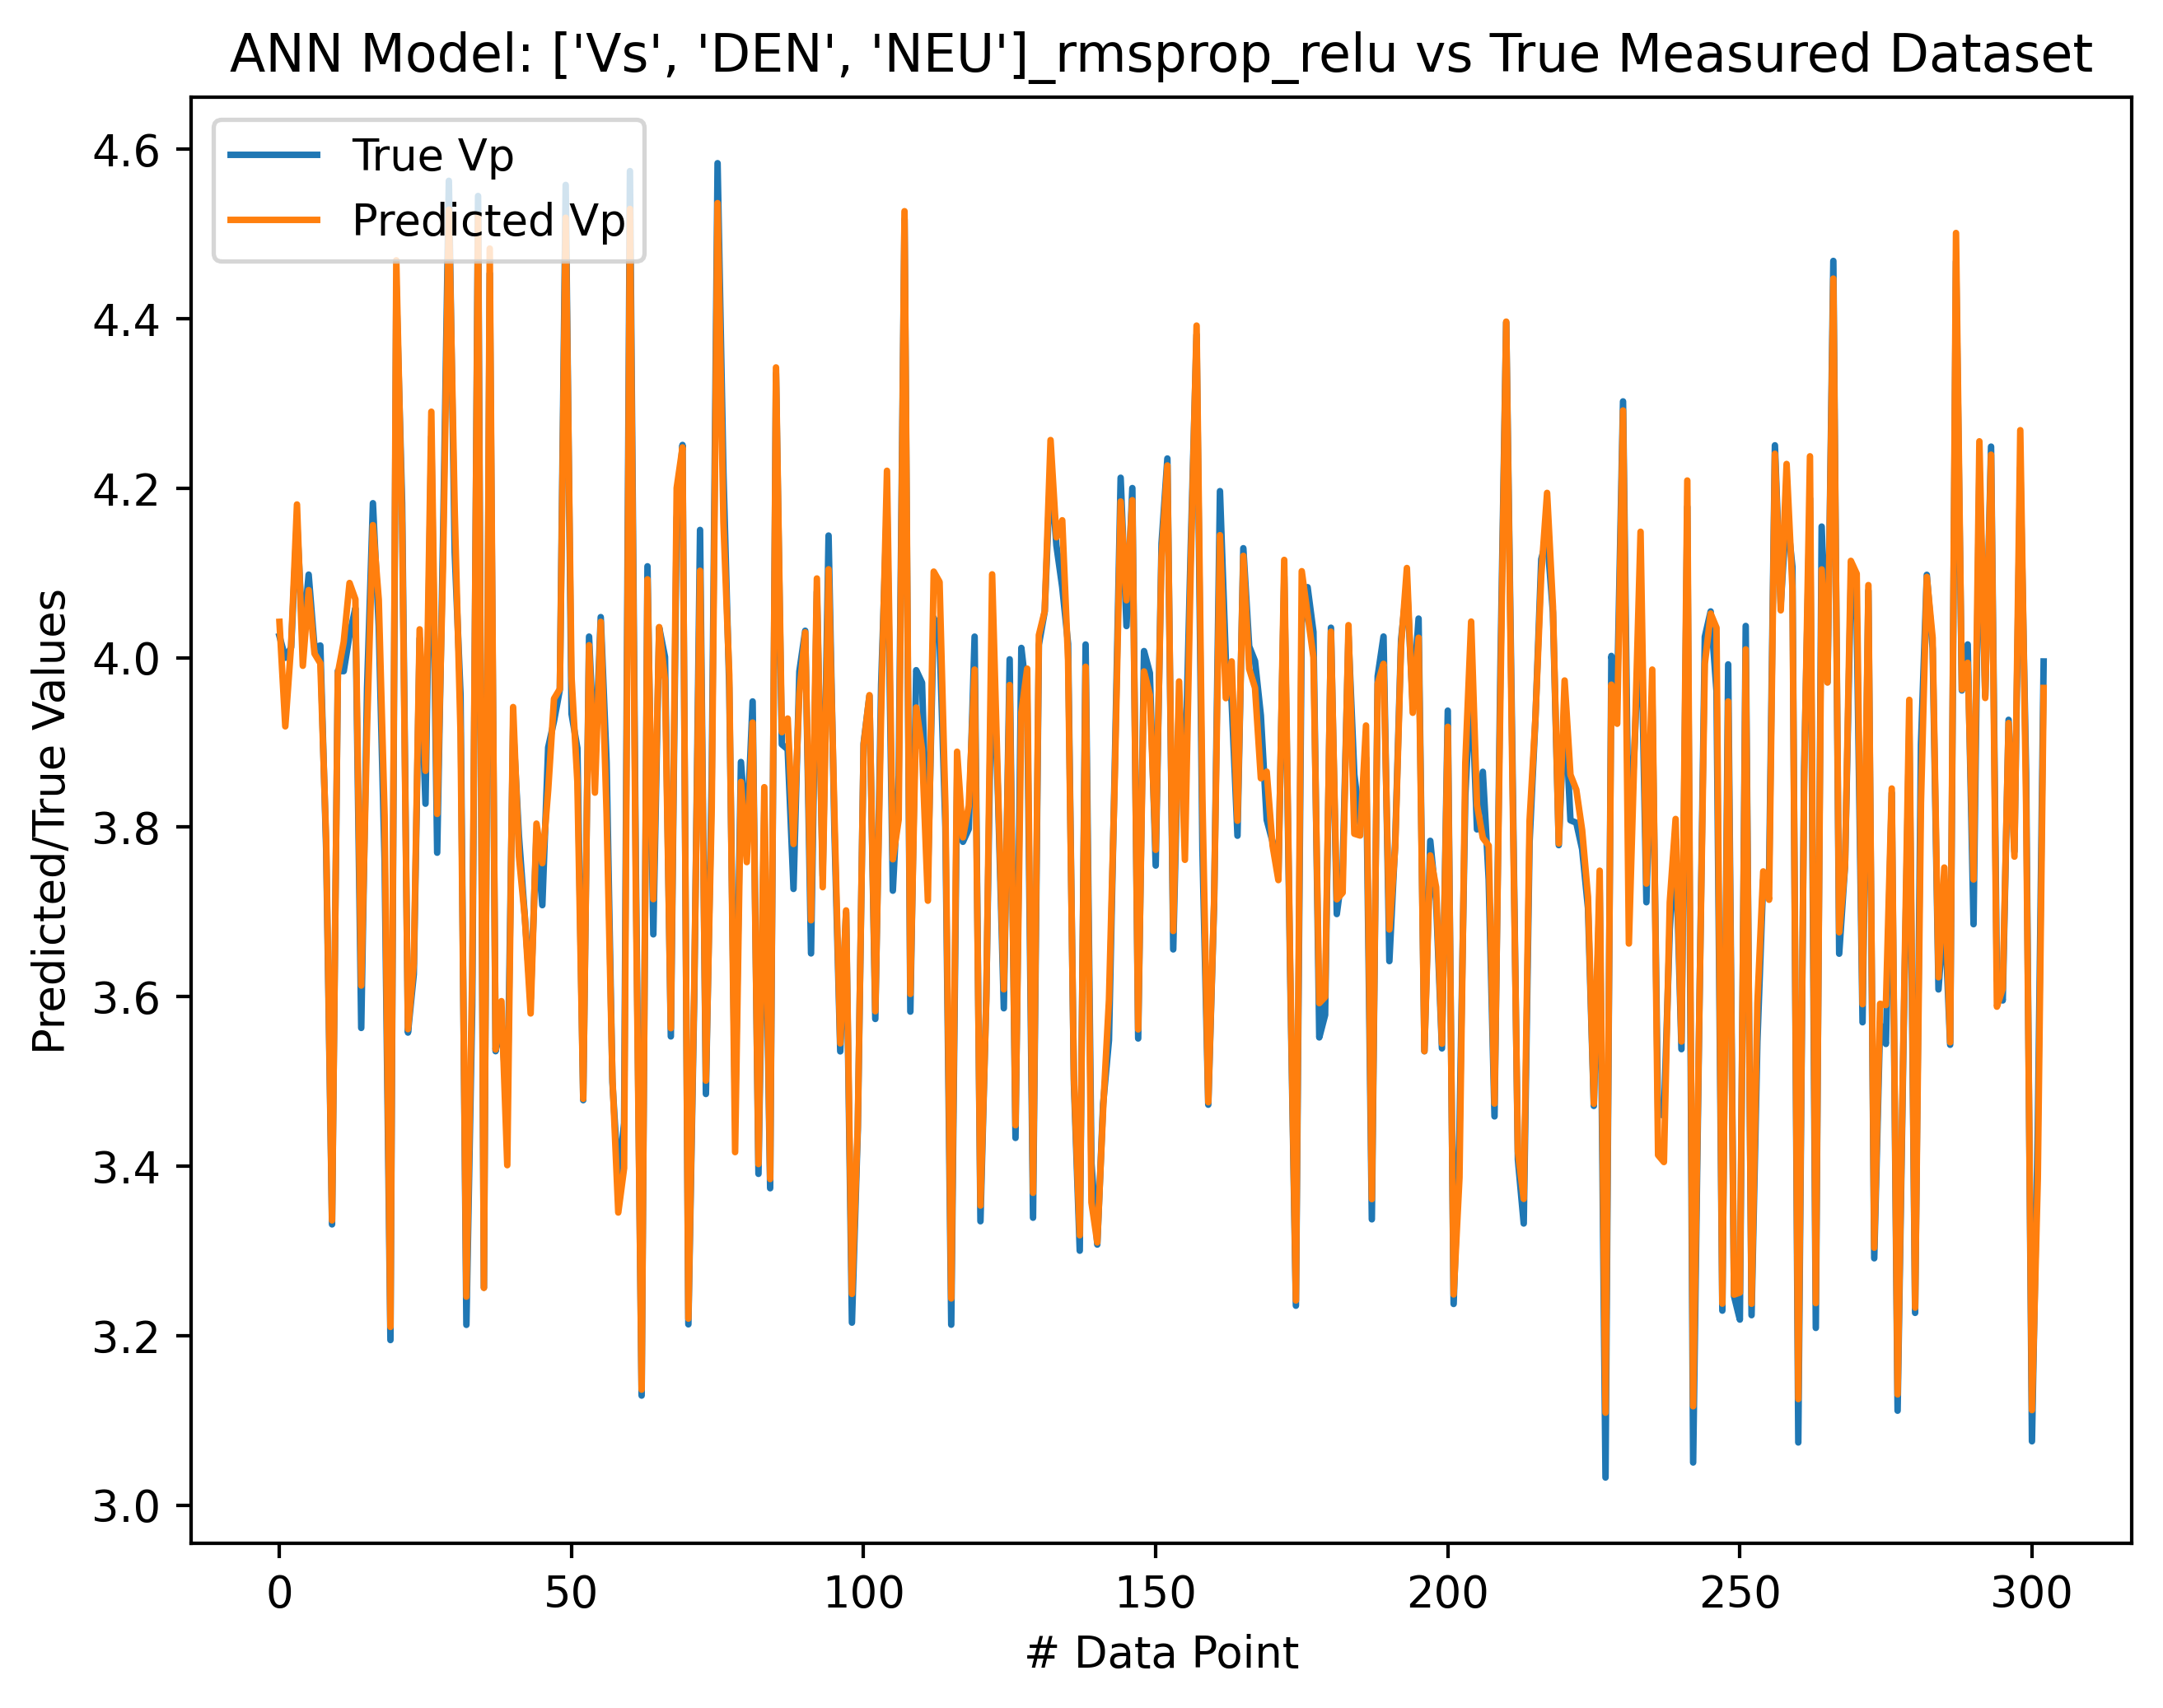

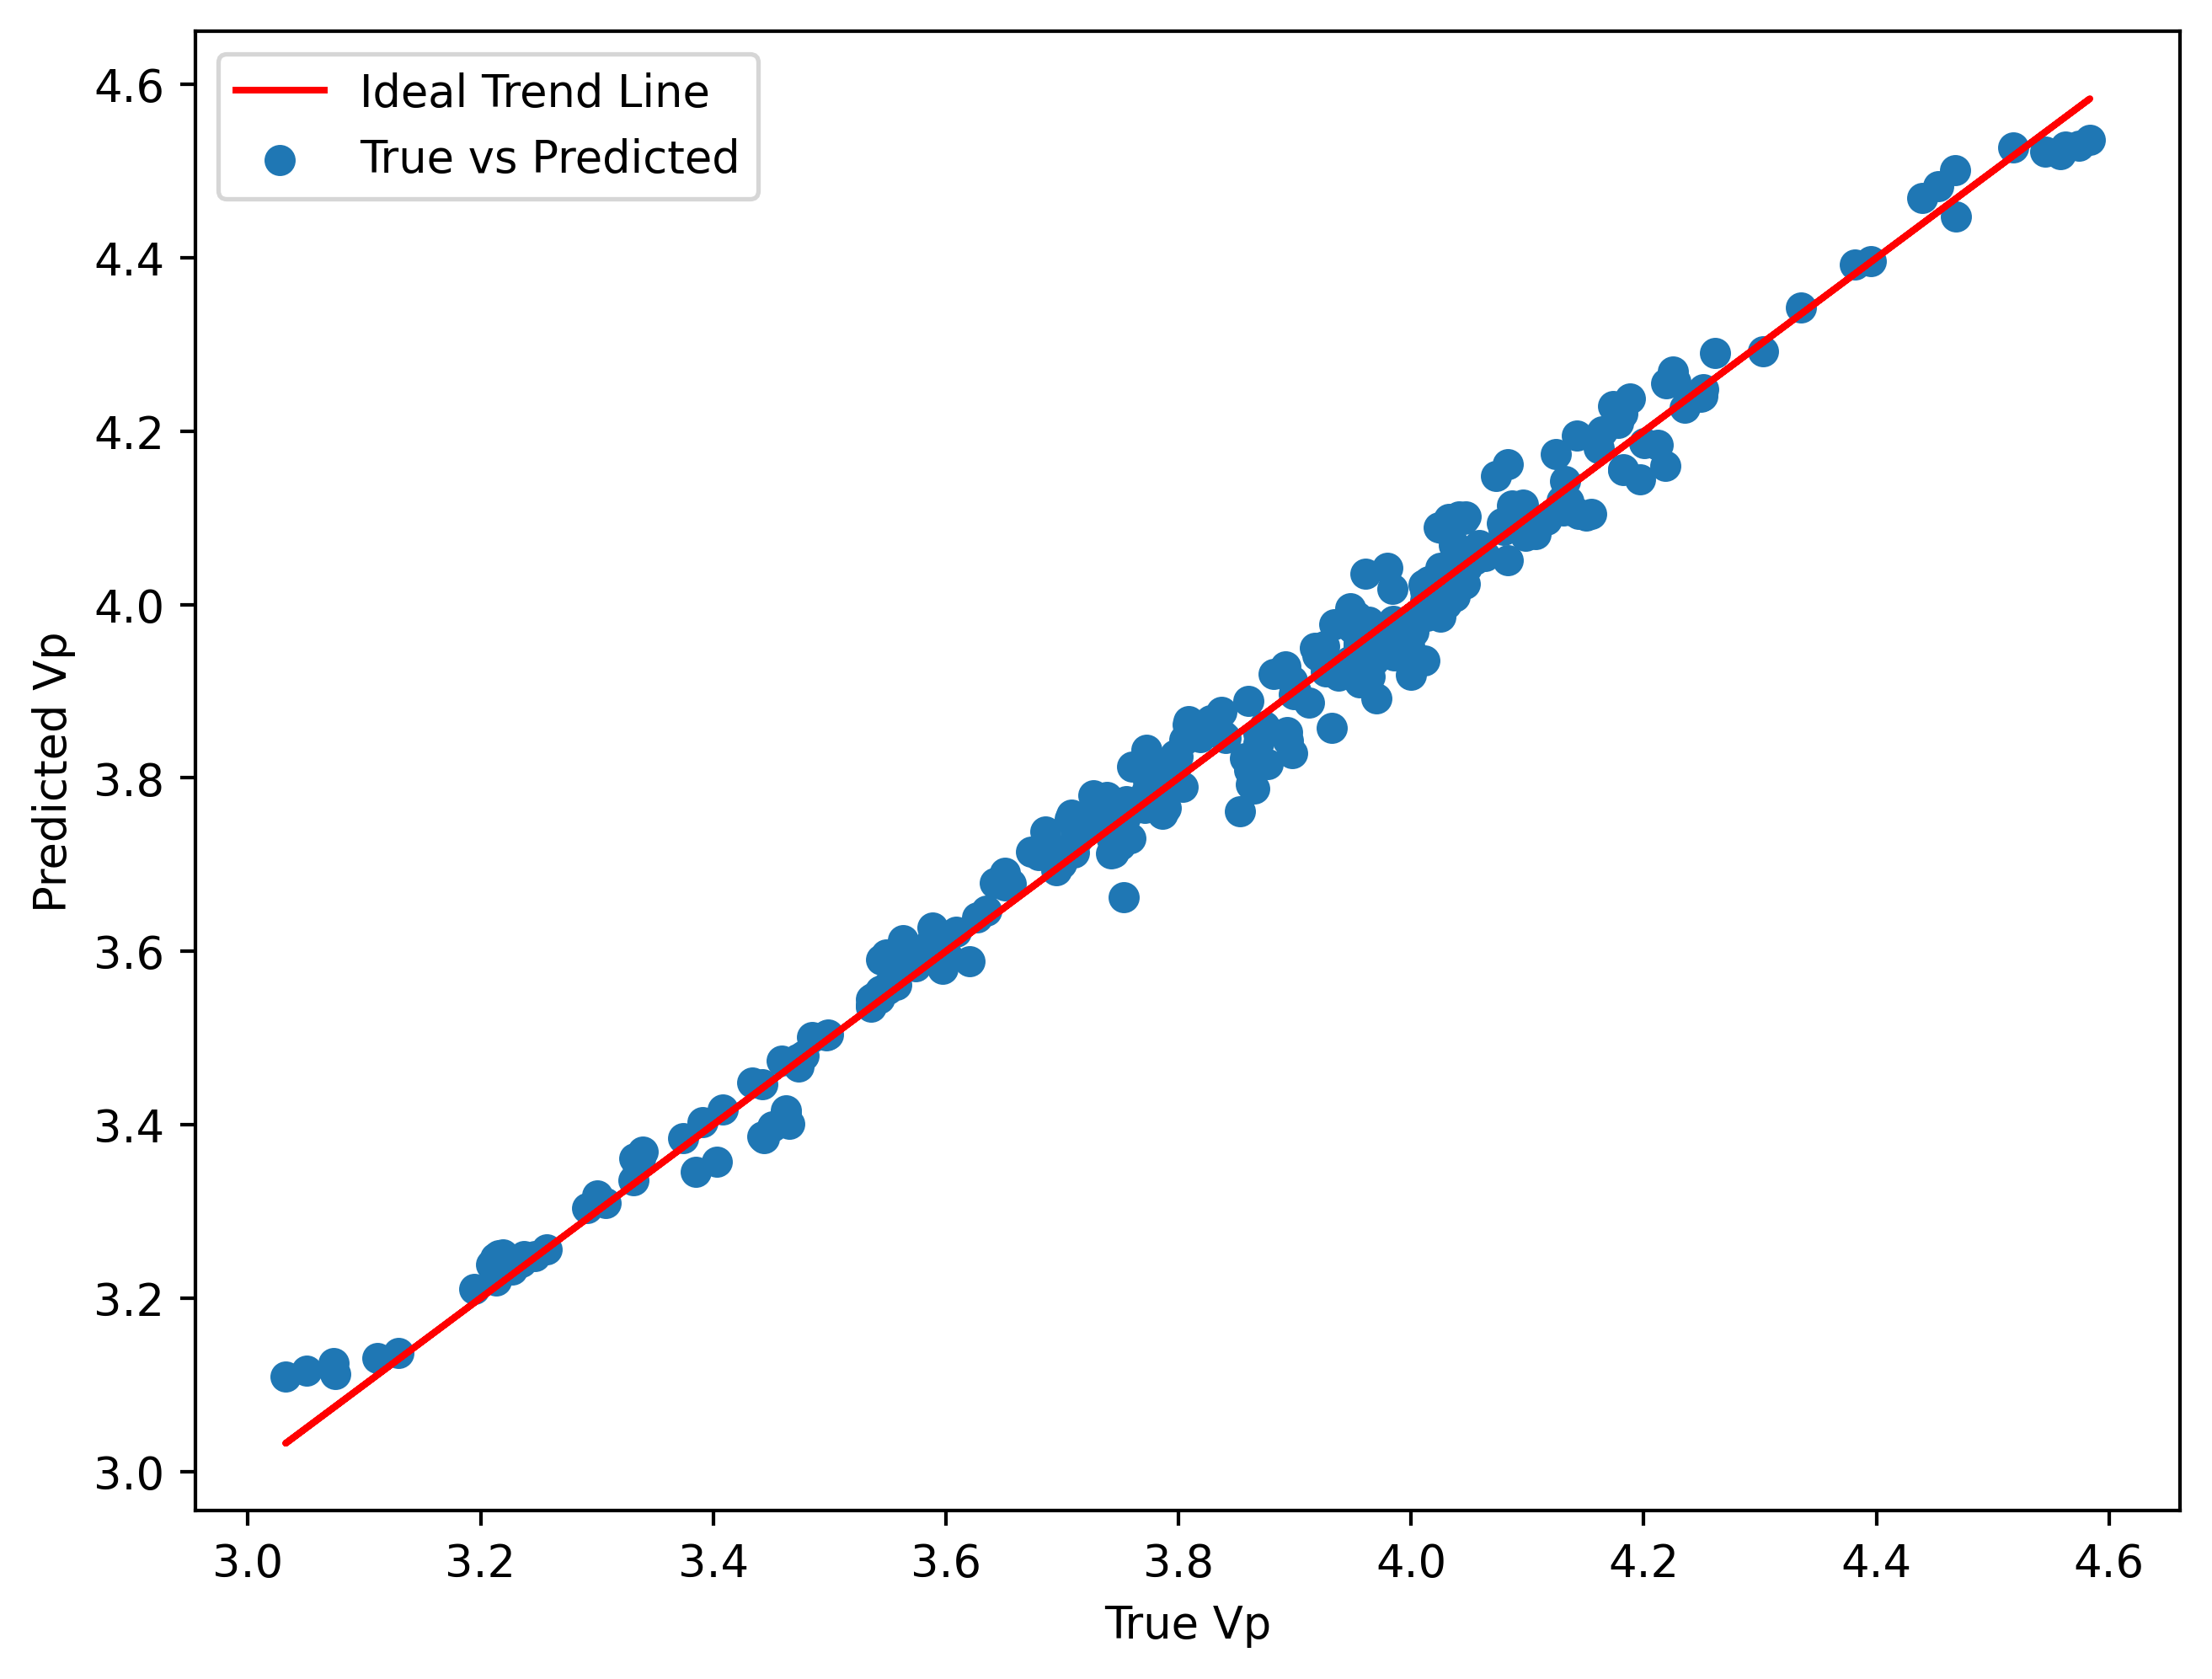

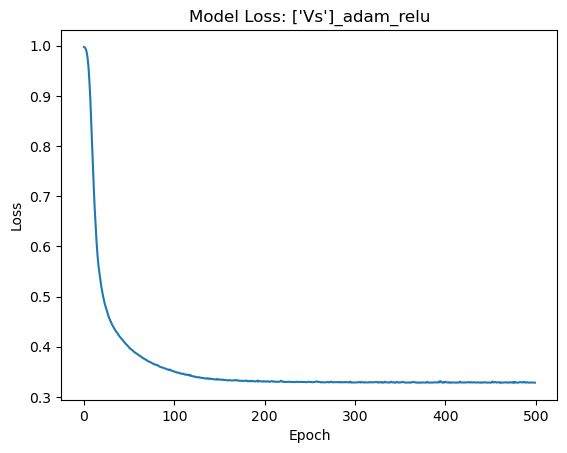

10/10 [==============================] - 0s 2ms/step


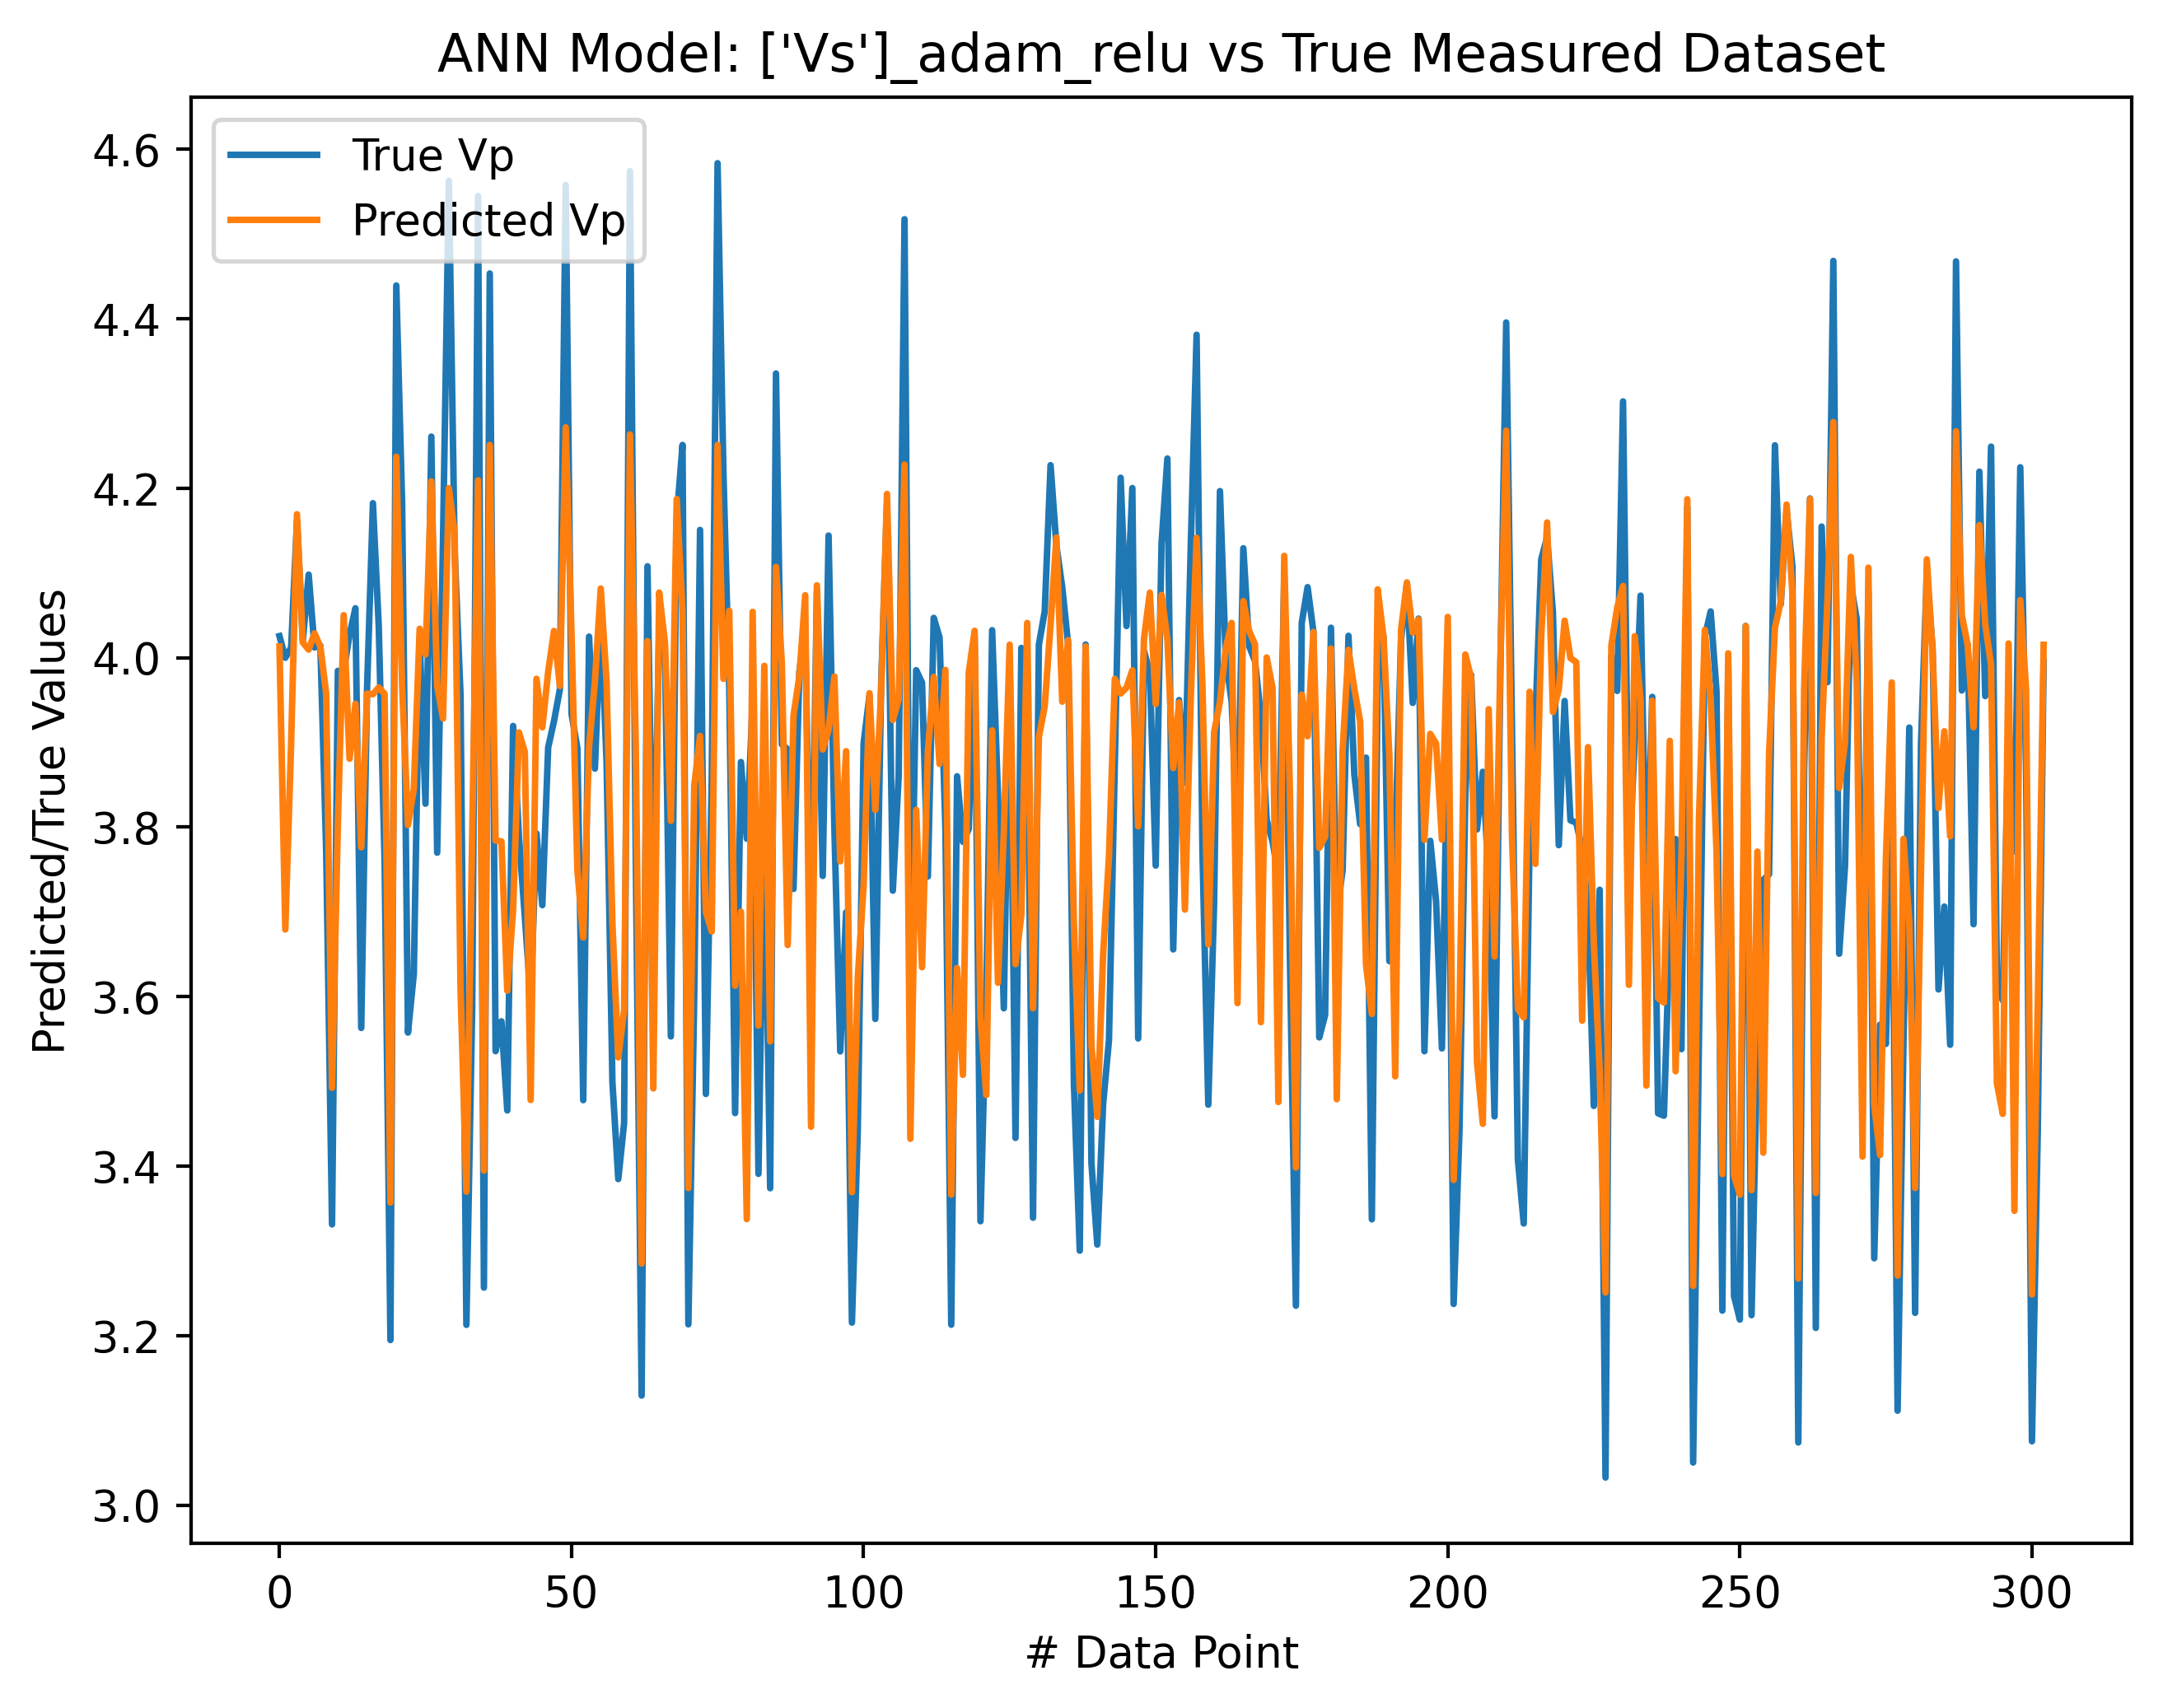

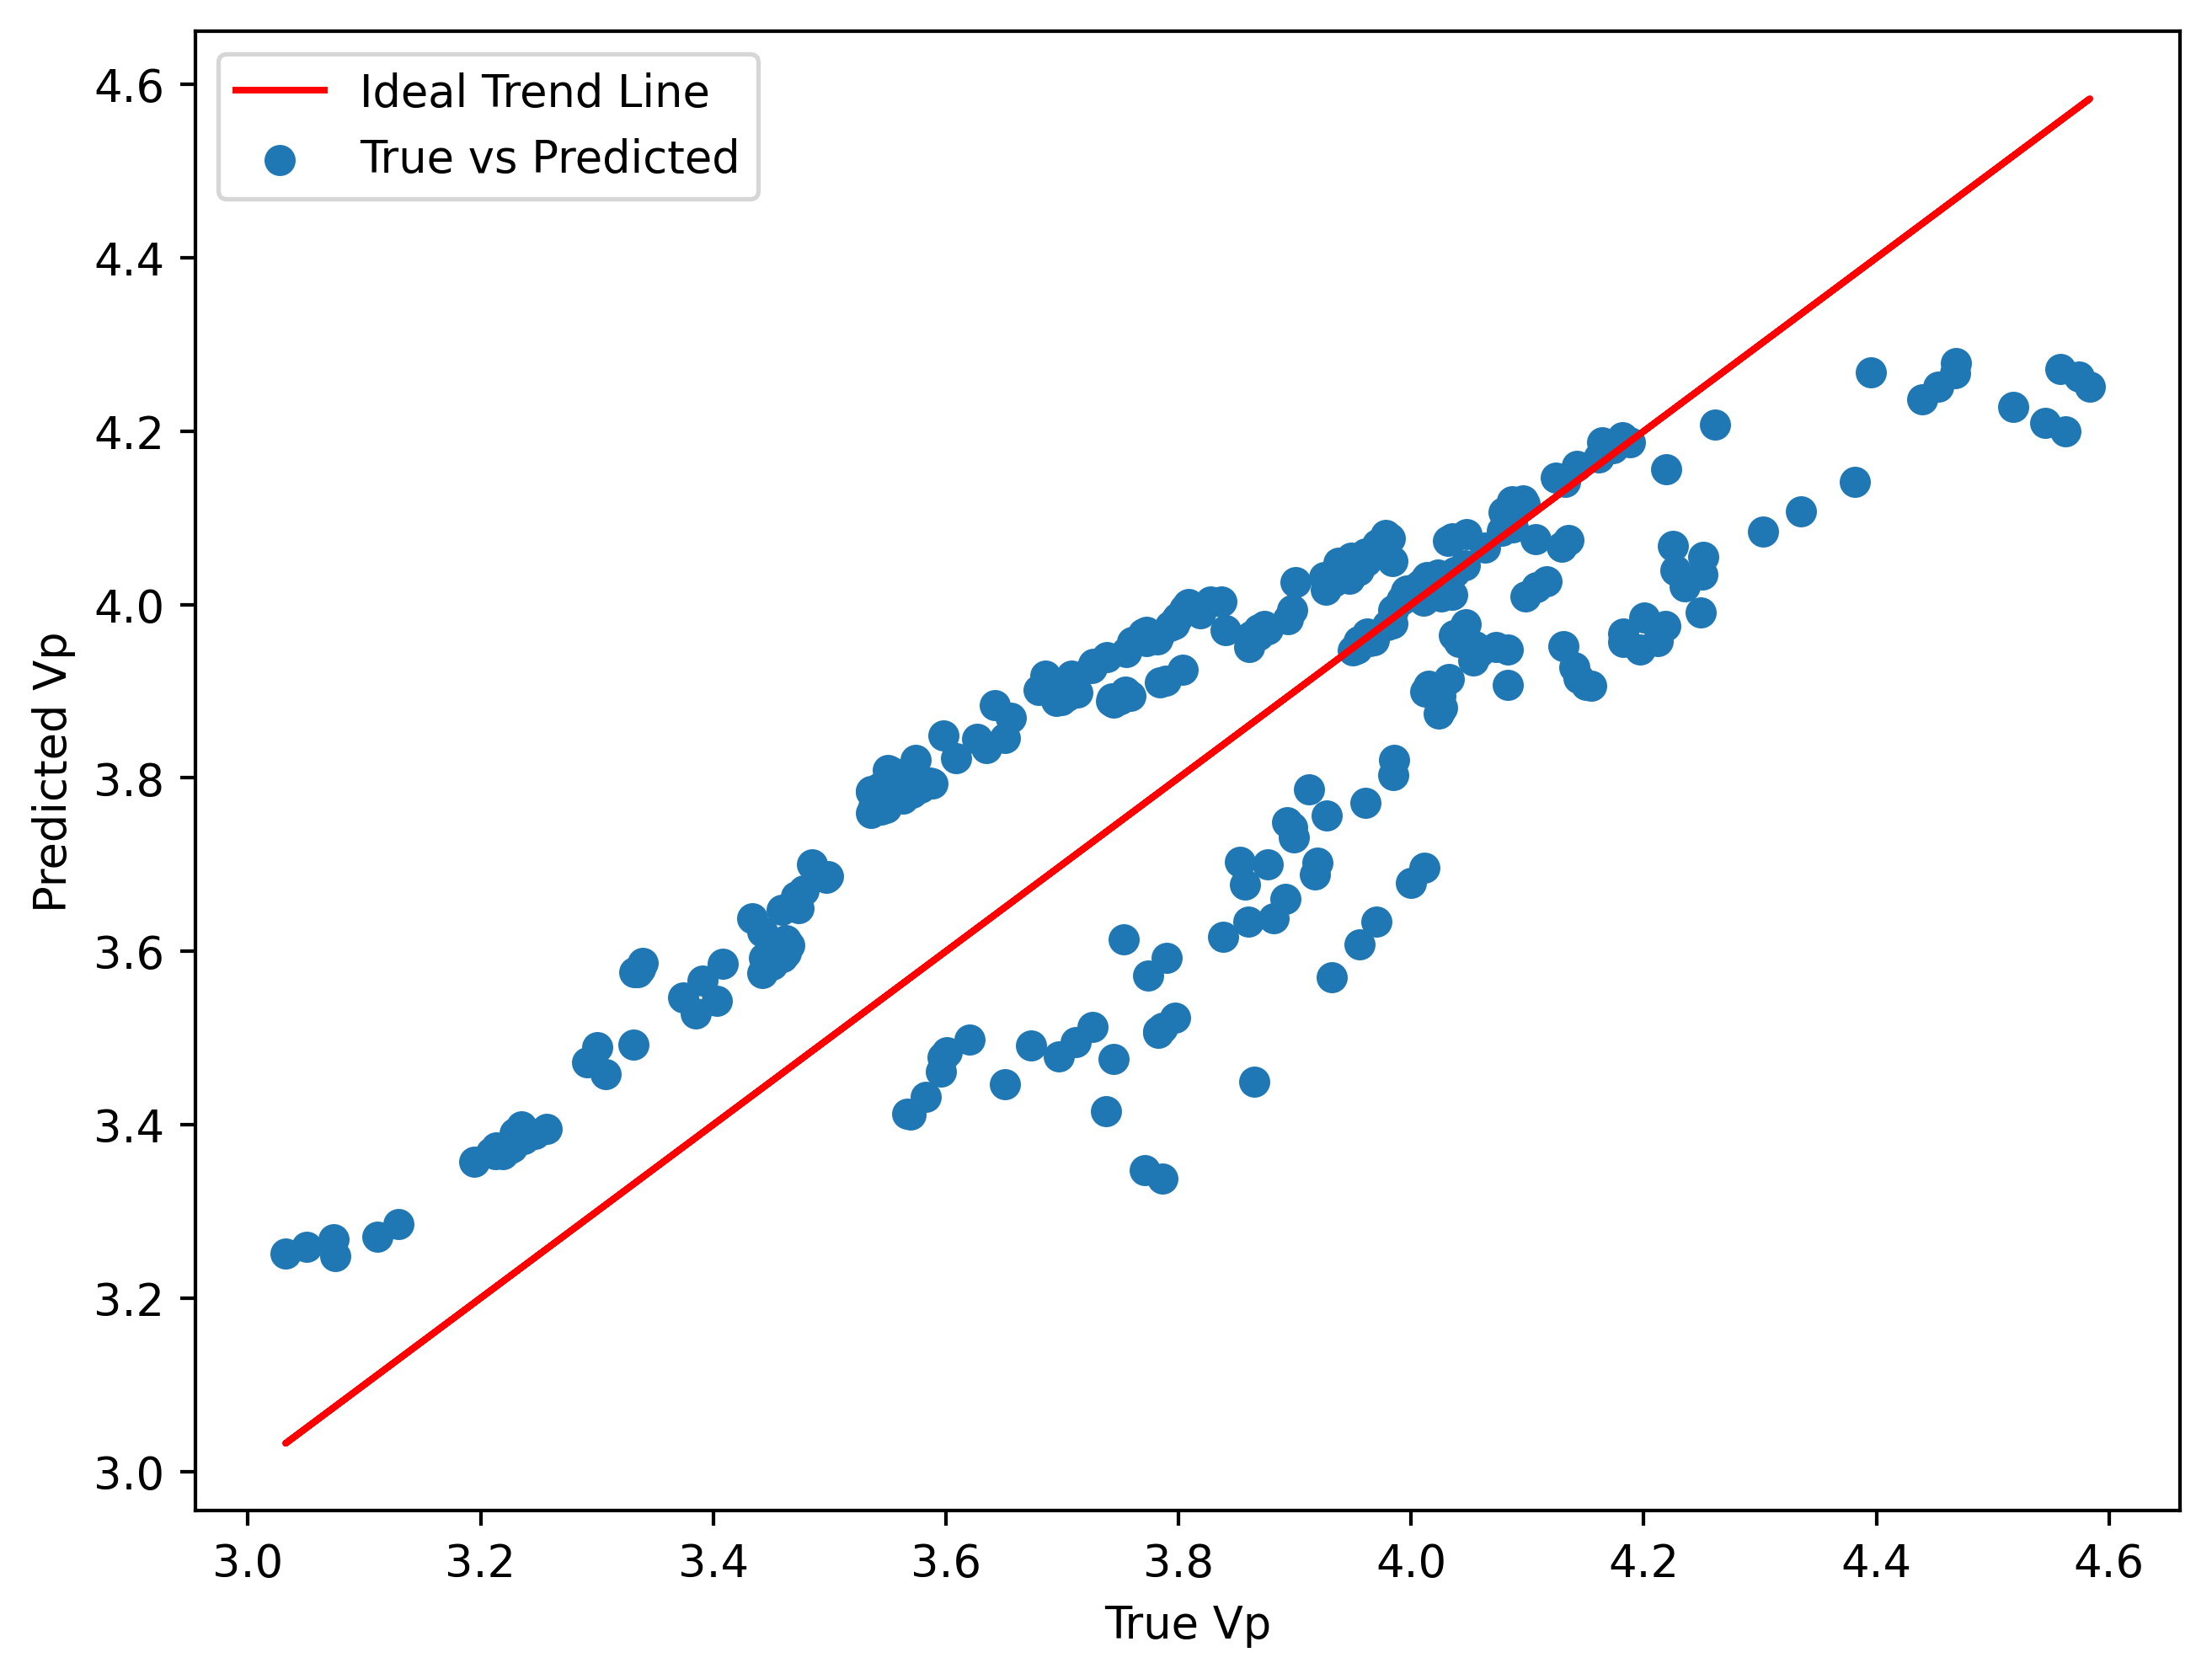

In [7]:
# Select the best and worst performing models
best_model_name = results_df.iloc[0]['Model']
worst_model_name = results_df.iloc[-1]['Model']

# Re-run the models for predictions using best and worst performing models
for model_name in [best_model_name, worst_model_name]:
    predictor_set, optimizer, activation_func = model_name.split('_', 2)
    
    # Extract the corresponding predictor set from the model name
    predictor_set = predictor_set.replace("[", "").replace("]", "").replace("'", "").split(", ")
    
    # Use the same data, no need to re-scale it again
    X = CleanedData[predictor_set].values
    y = CleanedData[TargetVariable].values

    # Reuse scaling (you can reuse the scaling logic from the original loop, don't repeat scaling)
    X = PredictorScaler.fit_transform(X)
    y = TargetVarScaler.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create the same model with the best/worst performing configuration
    model = create_ann_model(input_dim=X_train.shape[1], optimizer=optimizer, activation=activation_func)
    history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)

     # Plot the loss history
    plt.plot(history.history['loss'])
    plt.title(f'Model Loss: {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    # Predict and scale the results back
    predictions = model.predict(X_test)
    predictions = TargetVarScaler.inverse_transform(predictions)
    y_test_orig = TargetVarScaler.inverse_transform(y_test)

    # Plot predicted vs actual values
    plt.figure(figsize=(8, 6), dpi=380)
    plt.plot(y_test_orig)
    plt.plot(predictions)
    plt.title(f'ANN Model: {model_name} vs True Measured Dataset')
    plt.ylabel('Predicted/True Values')
    plt.xlabel('# Data Point')
    plt.legend(['True Vp', 'Predicted Vp'], loc='upper left')
    plt.show()

    # Scatter plot vs ideal trend
    plt.figure(figsize=(8, 6), dpi=380)
    plt.plot(y_test_orig, y_test_orig, 'r')
    plt.scatter(y_test_orig, predictions)
    plt.ylabel('Predicted Vp')
    plt.xlabel('True Vp')
    plt.legend(['Ideal Trend Line', 'True vs Predicted'], loc='upper left')
    plt.show()

This section selects the best and worst performing models based on their $R^2$ scores from the previous results. The best_model_name and worst_model_name are identified, and both models are then re-trained using the same dataset. We plot the loss history to show how it evolves during training and we also use plots to see how well its predictions does against the test set. 

The graph does a better job at showing us how the ANN model recognizes the pattern of the data. Even though we see that it overshoots a bit on the values, it follows the trends and flow of the actual results, meaning that it can actually read and understand the data it reads. Proving its usefullness in handling the complex relationships with the values. 

In this plot, we compare the ANN predictions with the true data, seeing how it looks with the ideal trend line. If the ANN model was perfectly accurate, we would have seen all the points directly on the line, but, we still see that the points scatter around the ideal trend line, following it closely. We can therefore again say that our ANN model has done a great job of learning the pattern and predicting accurate results by using the data we provide. 

This graph shows how the loss function of the ANN model evolves over the course of training. Loss is essentially the measure of error the model makes in its predictions, and the goal is to minimize it as training progresses.

At the beginning of training, the model starts with a relatively higher loss value of 0.0305, meaning that its initial predictions are less accurate. As the training progresses and the model adjusts its weights based on the backpropagation of errors, the loss steadily decreases, reaching around 0.0290 by the 500th epoch. This decline in loss demonstrates that the model is improving its ability to predict the target variable (Vp) more accurately over time.


### Reflections

### Conclusion

In conclusion, this part of the project successfully demonstrated the ability of an Artificial Neural Network (ANN) to predict Vp values based on the predictor variables Vs, DEN, and NEU. By preprocessing the data and applying a three-layer ANN model, we were able to get predictions that are close with the true measured values. The evaluation reflect that the model's predictions are fairly accurate, with a consistent downward trend in training loss over time. 

The results show that the ANN model is capable of learning and improving its predictions with further training. The scatter plot comparing the true values with the predicted values, as well as the comparison of predicted vs actual values, confirms that the model follows the general trend of the data well, though some minor deviations and overshooting were observed.

Overall, this work shows us that the use of neural networks in handling complex, non-linear relationships between input features and target variables, is a great tool for more accurate Vp predictions.

### References

GeeksForGeeks (2024) *Artificial Neural Networks and its Applications* https://www.geeksforgeeks.org/artificial-neural-networks-and-its-applications/

IBM (2024) *What is a neural network?* https://www.ibm.com/topics/neural-networks